<a href="https://colab.research.google.com/github/hasune613/hello-world/blob/main/BERT_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import urllib.request
import zipfile
import tarfile
import glob
import io

In [ ]:
data_dir = './data/'
if not os.path.exists(data_dir): # もし「data_dir」ファイルが存在していなかったら
    os.mkdir(data_dir) # 「data_dir」ファイルを作ってね

vocab_dir = './vocab/'
if not os.path.exists(vocab_dir): 
    os.mkdir(vocab_dir) 

weights_dir = './weights/'
if not os.path.exists(weights_dir): 
    os.mkdir(weights_dir) 

In [ ]:
# 単語集：ボキャブラリーをダウンロード

save_path="./vocab/bert-base-uncased-vocab.txt"
url = "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt"
urllib.request.urlretrieve(url, save_path)

('./vocab/bert-base-uncased-vocab.txt',
 <http.client.HTTPMessage at 0x7f7504329810>)

In [ ]:
# BERTの学習済みモデル 'bert-base-uncased'

# ダウンロード
save_path = "./weights/bert-base-uncased.tar.gz"
url = "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz"
urllib.request.urlretrieve(url, save_path)

# # 解凍
archive_file = "./weights/bert-base-uncased.tar.gz" # Uncasedは小文字化モードという意味
tar = tarfile.open(archive_file, 'r:gz') # gzip 圧縮で読み込み用にオープン。
tar.extractall('./weights/')
tar.close()
# フォルダ「weights」に「pytorch_model.bin」と「bert_config.json」ができる

In [ ]:
import math
import numpy as np
import torch
from torch import nn


## BERT_Baseのネットワークの設定ファイルの読み込み

In [ ]:
# 設定をconfig.jsonから読み込み、JSONの辞書変数をオブジェクト変数に変換
import json

config_file = './weights/bert_config.json'

# ファイルを開き、JSONとして読み込む
json_file = open(config_file,'r')
config = json.load(json_file)

config

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [ ]:
! pip -q install AttrDict

In [ ]:
from attrdict import AttrDict

In [ ]:
config = AttrDict(config)
config.hidden_act

'gelu'

## BERT用にLayerNormalization層を定義

In [ ]:
class BertLayerNorm(nn.Module):
    """LayerNormalization層 """

    def __init__(self, hidden_size, eps=1e-12):
        super(BertLayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(hidden_size))  # weightのこと
        self.beta = nn.Parameter(torch.zeros(hidden_size))  # biasのこと
        self.variance_epsilon = eps

    def forward(self, x):
        u = x.mean(-1, keepdim=True)
        s = (x - u).pow(2).mean(-1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.variance_epsilon)
        return self.gamma * x + self.beta


## Embeddingsモジュールの実装

In [ ]:

class BertEmbeddings(nn.Module):
        #文章の単語ID列と、1文目か2文目かの情報を、埋め込みベクトルに変換する
    

    def __init__(self, config):
        super(BertEmbeddings, self).__init__()

        # Token Embedding：単語IDを単語ベクトルに変換、
        # vocab_size = 30522でBERTの学習済みモデルで使用したボキャブラリーの量
        # hidden_size = 768 で特徴量ベクトルの長さは768
        self.word_embeddings = nn.Embedding(
            config.vocab_size, config.hidden_size, padding_idx=0)
        # （注釈）padding_idx=0はidx=0の単語のベクトルは0にする。BERTのボキャブラリーのidx=0が[PAD]である。

        # Transformer Positional Embedding：位置情報テンソルをベクトルに変換
        # Transformerの場合はsin、cosからなる固定値だったが、BERTは学習させる
        # max_position_embeddings = 512　で文の長さは512単語
        self.position_embeddings = nn.Embedding(
            config.max_position_embeddings, config.hidden_size)

        # Sentence Embedding：文章の1文目、2文目の情報をベクトルに変換
        # type_vocab_size = 2
        self.token_type_embeddings = nn.Embedding(
            config.type_vocab_size, config.hidden_size)

        # 作成したLayerNormalization層
        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=1e-12)

        # Dropout　'hidden_dropout_prob': 0.1
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, input_ids, token_type_ids=None):
        
        # input_ids： [batch_size, seq_len]の文章の単語IDの羅列
        # token_type_ids：[batch_size, seq_len]の各単語が1文目なのか、2文目なのかを示すid
        

        # 単語IDを単語ベクトルに変換
        words_embeddings = self.word_embeddings(input_ids)

        # token_type_idsがない場合は文章の全単語を1文目として、0にする
        # そこで、input_idsと同じサイズのゼロテンソルを作成
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)

        # [0, 1, 2 ・・・]と文章の長さだけ、数字が1つずつ昇順に入った
        # [batch_size, seq_len]のテンソルposition_idsを作成
        # position_idsを入力して、position_embeddings層から768次元のテンソルを取り出す
        seq_length = input_ids.size(1)  # 文章の長さ
        position_ids = torch.arange(
            seq_length, dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
        position_embeddings = self.position_embeddings(position_ids)

        # 3つの埋め込みテンソルを足し合わせる [batch_size, seq_len, hidden_size]
        embeddings = words_embeddings + position_embeddings + token_type_embeddings

        # LayerNormalizationとDropoutを実行
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)

        return embeddings

    

## BertLayerモジュール（Transformer）

In [ ]:
class BertLayer(nn.Module):
    
    def __init__(self, config):
        super(BertLayer, self).__init__()

        # Self-Attention部分
        self.attention = BertAttention(config)

        # Self-Attentionの出力を処理する全結合層
        self.intermediate = BertIntermediate(config)

        # Self-Attentionによる特徴量とBertLayerへの元の入力を足し算する層
        self.output = BertOutput(config)

    def forward(self, hidden_states, attention_mask, attention_show_flg=False):
        
        # hidden_states：Embedderモジュールの出力テンソル[batch_size, seq_len, hidden_size]
        # attention_mask：Transformerのマスクと同じ働きのマスキング
        # attention_show_flg：Self-Attentionの重みを返すかのフラグ
        
        if attention_show_flg == True:
            # attention_showのときは、attention_probsもリターンする
            attention_output, attention_probs = self.attention(
                hidden_states, attention_mask, attention_show_flg)
            intermediate_output = self.intermediate(attention_output)
            layer_output = self.output(intermediate_output, attention_output)
            return layer_output, attention_probs

        elif attention_show_flg == False:
            attention_output = self.attention(
                hidden_states, attention_mask, attention_show_flg)
            intermediate_output = self.intermediate(attention_output)
            layer_output = self.output(intermediate_output, attention_output)

            return layer_output  # [batch_size, seq_length, hidden_size]

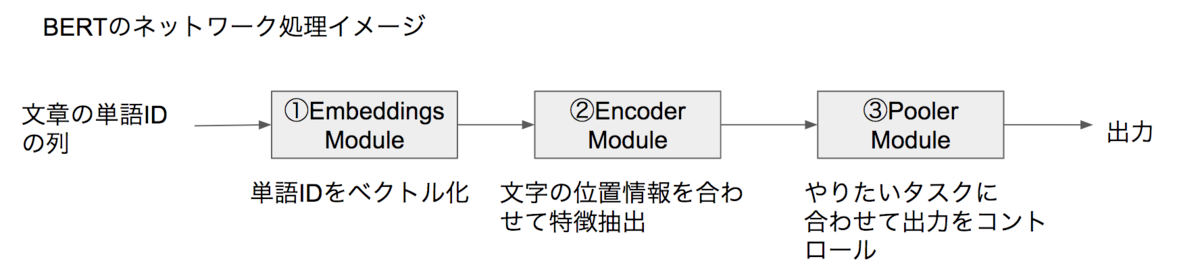

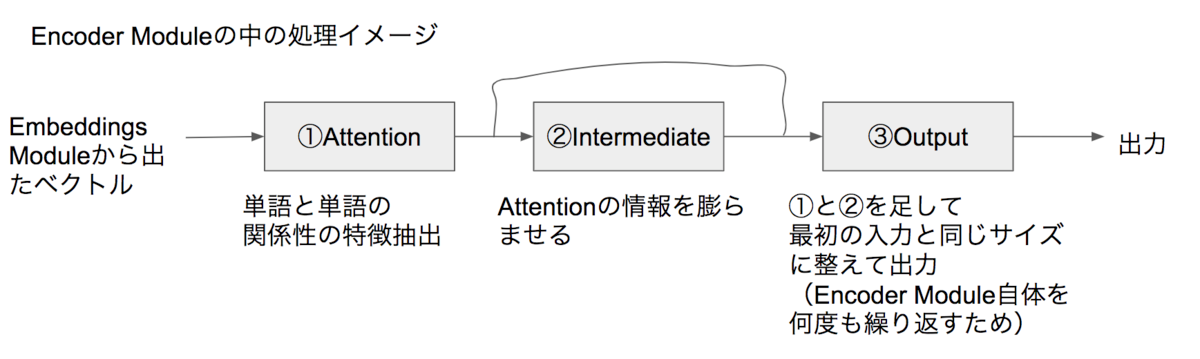

### Attention

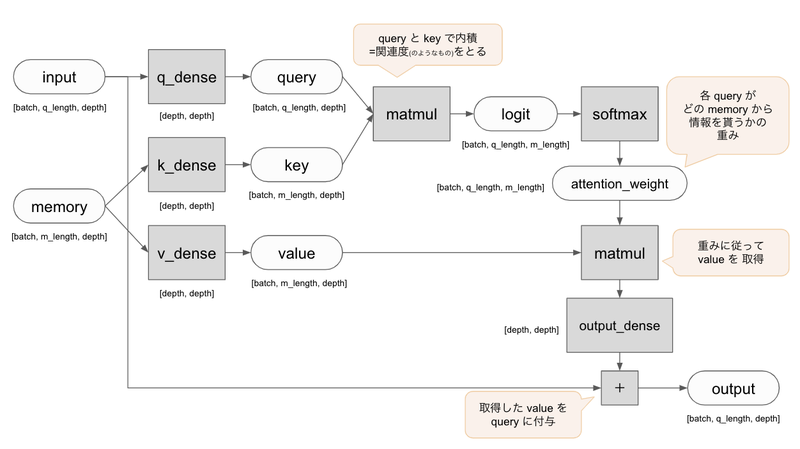

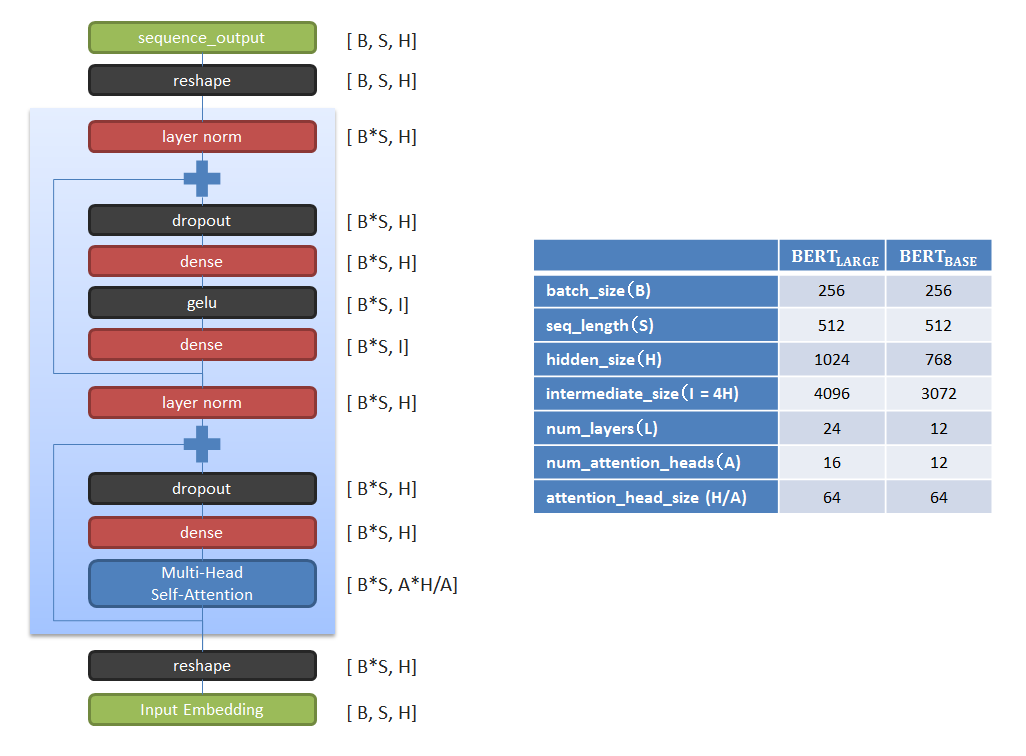

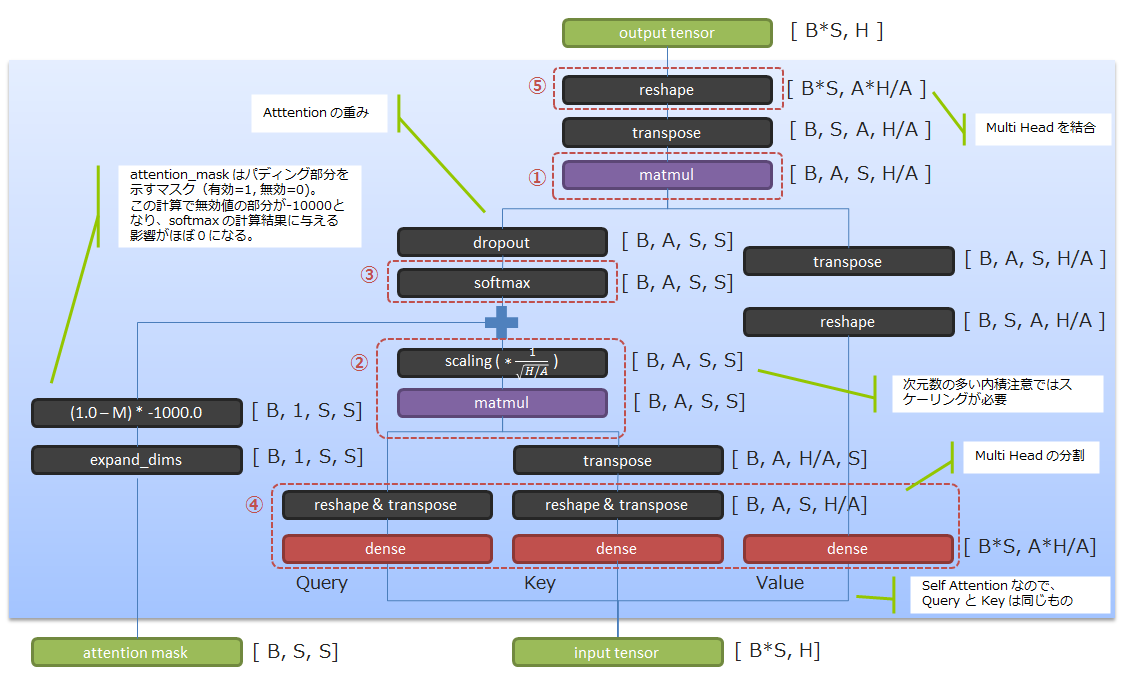

In [ ]:
class BertAttention(nn.Module):
    
    def __init__(self, config):
        super(BertAttention, self).__init__()
        self.selfattn = BertSelfAttention(config)
        self.output = BertSelfOutput(config)

    def forward(self, input_tensor, attention_mask, attention_show_flg=False):
        
        # input_tensor：Embeddingsモジュールもしくは前段のBertLayerからの出力
        # attention_mask：Transformerのマスクと同じ働きのマスキングです
        # attention_show_flg：Self-Attentionの重みを返すかのフラグ
        
        if attention_show_flg == True:
            # attention_showのときは、attention_probsもリターン
            self_output, attention_probs = self.selfattn(input_tensor, attention_mask, attention_show_flg)
            attention_output = self.output(self_output, input_tensor)
            return attention_output, attention_probs
        
        elif attention_show_flg == False:
            self_output = self.selfattn(input_tensor, attention_mask, attention_show_flg)
            attention_output = self.output(self_output, input_tensor)
            return attention_output

In [ ]:
"""
{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

"""

class BertSelfAttention(nn.Module):
    

    def __init__(self, config):
        super(BertSelfAttention, self).__init__()

        self.num_attention_heads = config.num_attention_heads
        # num_attention_heads': 12

        self.attention_head_size = int(
            config.hidden_size / config.num_attention_heads)  # 768/12=64
        self.all_head_size = self.num_attention_heads * \
            self.attention_head_size  # = 'hidden_size': 768

        # Self-Attentionの特徴量を作成する全結合層
        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        # Dropout
        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

    def transpose_for_scores(self, x):
        # multi-head Attention用にテンソルの形を変換する
        # [batch_size, seq_len, hidden] → [batch_size, 12, seq_len, hidden/12] 
        
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states, attention_mask, attention_show_flg=False):
        
        # hidden_states：Embeddingsモジュールもしくは前段のBertLayerからの出力
        # attention_mask：Transformerのマスクと同じ働きのマスキングです
        # attention_show_flg：Self-Attentionの重みを返すかのフラグ
        
        # 入力を全結合層で特徴量変換
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        # multi-head Attention用にテンソルの形を変換
        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        # 特徴量同士を掛け算して似ている度合をAttention_scoresとして求める
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores /math.sqrt(self.attention_head_size)

        # マスクがある部分にはマスクをかける
        attention_scores = attention_scores + attention_mask
        
        # このあとSoftmaxで正規化する。
        # attention_maskには、もともと0か-inf（-10000.0）が入っているので足し算。

        # Attentionを正規化
        attention_probs = nn.Softmax(dim=-1)(attention_scores)

        # ドロップアウト
        attention_probs = self.dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)

        # multi-head Attentionのテンソルの形をもとに戻す
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)

        # attention_showのときは、attention_probsもリターンする
        if attention_show_flg == True:
            return context_layer, attention_probs
        elif attention_show_flg == False:
            return context_layer


In [ ]:
class BertSelfOutput(nn.Module):
        # BertSelfAttentionの出力を処理する全結合層

    def __init__(self, config):
        super(BertSelfOutput, self).__init__()

        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(config.hidden_dropout_prob) # 'hidden_dropout_prob': 0.1
       

    def forward(self, hidden_states, input_tensor):
        
        # hidden_states：BertSelfAttentionの出力テンソル
        # input_tensor：Embeddingsモジュールもしくは前段のBertLayerからの出力
        
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states

In [ ]:
def gelu(x):
   
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

In [ ]:
class BertIntermediate(nn.Module):
    
    def __init__(self, config):
        super(BertIntermediate, self).__init__()
        
        # 全結合層：'hidden_size': 768、'intermediate_size': 3072
        self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
        
        # 活性化関数gelu
        self.intermediate_act_fn = gelu
            
    def forward(self, hidden_states):
        
        # hidden_states： BertAttentionの出力テンソル
        
        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states) 
        return hidden_states

In [ ]:
class BertOutput(nn.Module):
    
    def __init__(self, config):
        super(BertOutput, self).__init__()

        # 全結合層：'intermediate_size': 3072、'hidden_size': 768
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)

        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=1e-12)

        # 'hidden_dropout_prob': 0.1
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        
        # hidden_states： BertIntermediateの出力テンソル
        # input_tensor：BertAttentionの出力テンソル
        
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states

## BertLayerモジュールの繰り返し部分

In [ ]:
# BertLayerモジュールの繰り返し部分モジュールの繰り返し部分です


class BertEncoder(nn.Module):
    def __init__(self, config):
        
        super(BertEncoder, self).__init__()

        # config.num_hidden_layers(12 個)のBertLayerモジュールを作成
        self.layer = nn.ModuleList([BertLayer(config)
                                    for _ in range(config.num_hidden_layers)])

    def forward(self, hidden_states, attention_mask, output_all_encoded_layers=True, attention_show_flg=False):
        
        # hidden_states：Embeddingsモジュールの出力
        # attention_mask：Transformerのマスクと同じ働きのマスキングです
        # output_all_encoded_layers：返り値を全TransformerBlockモジュールの出力or最終層だけにするかのフラグ。
        # attention_show_flg：Self-Attentionの重みを返すかのフラグ
        

        # 返り値として使うリスト
        all_encoder_layers = []

        # BertLayerモジュールの処理を繰り返す
        for layer_module in self.layer:

            if attention_show_flg == True:
                
                hidden_states, attention_probs = layer_module(
                    hidden_states, attention_mask, attention_show_flg)
            elif attention_show_flg == False:
                hidden_states = layer_module(
                    hidden_states, attention_mask, attention_show_flg)

            # 返り値にBertLayerから出力された特徴量を12層分、すべて使用する場合の処理
            if output_all_encoded_layers:
                all_encoder_layers.append(hidden_states)

        # 返り値に最後のBertLayerから出力された特徴量だけを使う場合の処理
        if not output_all_encoded_layers:
            all_encoder_layers.append(hidden_states)

        # attention_showのときは、attention_probs（最後の12段目）もリターンする
        if attention_show_flg == True:
            return all_encoder_layers, attention_probs
        elif attention_show_flg == False:
            return all_encoder_layers

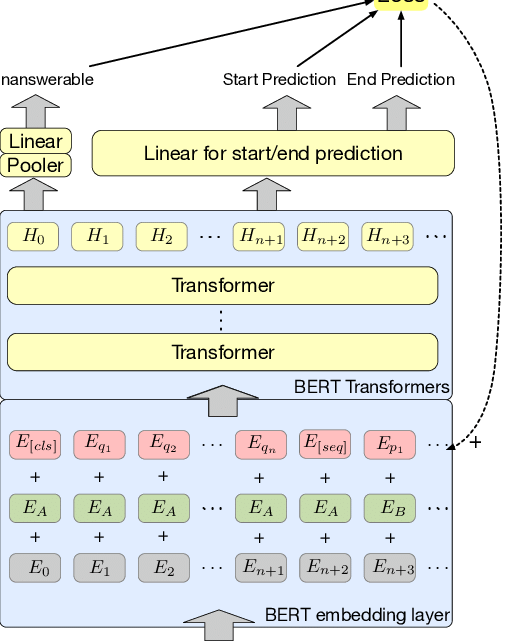

In [ ]:
class BertPooler(nn.Module):
    # 入力文章の1単語目[cls]の特徴量を変換して保持するためのモジュール

    def __init__(self, config):
        super(BertPooler, self).__init__()

        # 全結合層、'hidden_size': 768
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.Tanh()

    def forward(self, hidden_states):
        # 1単語目の特徴量を取得
        first_token_tensor = hidden_states[:, 0]

        # 全結合層で特徴量変換
        pooled_output = self.dense(first_token_tensor)

        # 活性化関数Tanhを計算
        pooled_output = self.activation(pooled_output)

        return pooled_output

In [ ]:
# 動作確認

# 入力の単語ID列、batch_sizeは2つ
input_ids = torch.LongTensor([[31, 51, 12, 23, 99], [15, 5, 1, 0, 0]])
print("入力の単語ID列のテンソルサイズ：", input_ids.shape)

# マスク
attention_mask = torch.LongTensor([[1, 1, 1, 1, 1], [1, 1, 1, 0, 0]])
print("入力のマスクのテンソルサイズ：", attention_mask.shape)

# 文章のID。2つのミニバッチそれぞれについて、0が1文目、1が2文目を示す
token_type_ids = torch.LongTensor([[0, 0, 1, 1, 1], [0, 1, 1, 1, 1]])
print("入力の文章IDのテンソルサイズ：", token_type_ids.shape)


# BERTの各モジュールを用意
embeddings = BertEmbeddings(config)
encoder = BertEncoder(config)
pooler = BertPooler(config)

# マスクの変形　[batch_size, 1, 1, seq_length]にする
# Attentionをかけない部分はマイナス無限にしたいので、代わりに-10000をかけ算しています
extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)
extended_attention_mask = extended_attention_mask.to(dtype=torch.float32)
extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0
print("拡張したマスクのテンソルサイズ：", extended_attention_mask.shape)

# 順伝搬する
out1 = embeddings(input_ids, token_type_ids)
print("BertEmbeddingsの出力テンソルサイズ：", out1.shape)

out2 = encoder(out1, extended_attention_mask)
# out2は、[minibatch, seq_length, embedding_dim]が12個のリスト
print("BertEncoderの最終層の出力テンソルサイズ：", out2[0].shape)

out3 = pooler(out2[-1])  # out2は12層の特徴量のリストになっているので一番最後を使用
print("BertPoolerの出力テンソルサイズ：", out3.shape)

入力の単語ID列のテンソルサイズ： torch.Size([2, 5])
入力のマスクのテンソルサイズ： torch.Size([2, 5])
入力の文章IDのテンソルサイズ： torch.Size([2, 5])
拡張したマスクのテンソルサイズ： torch.Size([2, 1, 1, 5])
BertEmbeddingsの出力テンソルサイズ： torch.Size([2, 5, 768])
BertEncoderの最終層の出力テンソルサイズ： torch.Size([2, 5, 768])
BertPoolerの出力テンソルサイズ： torch.Size([2, 768])


## 全部をつなげてBERTモデルにする

In [ ]:
class BertModel(nn.Module):
    

    def __init__(self, config):
        super(BertModel, self).__init__()

        # 3つのモジュールを作成
        self.embeddings = BertEmbeddings(config)
        self.encoder = BertEncoder(config)
        self.pooler = BertPooler(config)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, output_all_encoded_layers=True, attention_show_flg=False):
        
        # input_ids： [batch_size, sequence_length]の文章の単語IDの羅列
        # token_type_ids： [batch_size, sequence_length]の、各単語が1文目なのか、2文目なのかを示すid
        # attention_mask：Transformerのマスクと同じ働きのマスキングです
        # output_all_encoded_layers：最終出力に12段のTransformerの全部をリストで返すか、最後だけかを指定
        # attention_show_flg：Self-Attentionの重みを返すかのフラグ
        

        # Attentionのマスクと文の1文目、2文目のidが無ければ作成する
        if attention_mask is None:
            attention_mask = torch.ones_like(input_ids)
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)

        # マスクの変形　[minibatch, 1, 1, seq_length]にする
        # 後ほどmulti-head Attentionで使用できる形にしたいので
        extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)

        # マスクは0、1だがソフトマックスを計算したときにマスクになるように、0と-infにする
        # -infの代わりに-10000にしておく
        extended_attention_mask = extended_attention_mask.to(
            dtype=torch.float32)
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

        # 順伝搬させる
        # BertEmbeddinsモジュール
        embedding_output = self.embeddings(input_ids, token_type_ids)

        # BertLayerモジュール（Transformer）を繰り返すBertEncoderモジュール
        if attention_show_flg == True:
            # attention_showのときは、attention_probsもリターンする

            encoded_layers, attention_probs = self.encoder(embedding_output,
                                                           extended_attention_mask,
                                                           output_all_encoded_layers, attention_show_flg)

        elif attention_show_flg == False:
            encoded_layers = self.encoder(embedding_output,
                                          extended_attention_mask,
                                          output_all_encoded_layers, attention_show_flg)

        # BertPoolerモジュール
        # encoderの一番最後のBertLayerから出力された特徴量を使う
        pooled_output = self.pooler(encoded_layers[-1])

        # output_all_encoded_layersがFalseの場合はリストではなく、テンソルを返す
        if not output_all_encoded_layers:
            encoded_layers = encoded_layers[-1]

        # attention_showのときは、attention_probs（1番最後の）もリターンする
        if attention_show_flg == True:
            return encoded_layers, pooled_output, attention_probs
        elif attention_show_flg == False:
            return encoded_layers, pooled_output

In [ ]:
# 動作確認
# 入力の用意
input_ids = torch.LongTensor([[31, 51, 12, 23, 99], [15, 5, 1, 0, 0]])
attention_mask = torch.LongTensor([[1, 1, 1, 1, 1], [1, 1, 1, 0, 0]])
token_type_ids = torch.LongTensor([[0, 0, 1, 1, 1], [0, 1, 1, 1, 1]])

# BERTモデルを作る
net = BertModel(config)

# 順伝搬させる
encoded_layers, pooled_output, attention_probs = net(
    input_ids, token_type_ids, attention_mask, output_all_encoded_layers=False, attention_show_flg=True)

print("encoded_layersのテンソルサイズ：", encoded_layers.shape)
print("pooled_outputのテンソルサイズ：", pooled_output.shape)
print("attention_probsのテンソルサイズ：", attention_probs.shape)

encoded_layersのテンソルサイズ： torch.Size([2, 5, 768])
pooled_outputのテンソルサイズ： torch.Size([2, 768])
attention_probsのテンソルサイズ： torch.Size([2, 12, 5, 5])


## BERTを用いたbank（銀行）とbank（土手）の単語ベクトル表現の比較
## 学習済みモデルのロード

In [ ]:
weights_path = './weights/pytorch_model.bin'
loaded_state_dict = torch.load(weights_path)
for s in loaded_state_dict.keys():
    print(s)

bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.gamma
bert.embeddings.LayerNorm.beta
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.gamma
bert.encoder.layer.0.attention.output.LayerNorm.beta
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.gamma
bert.encoder.layer.0.output.LayerNorm.beta
bert.encoder.layer.1.attention.self.query.weight
bert.encode

In [ ]:
# モデルの用意
net = BertModel(config)
net.eval()

# 現在のネットワークモデルのパラメータ名
param_names = []

for name, param in net.named_parameters():
    print(name)
    param_names.append(name)
    


embeddings.word_embeddings.weight
embeddings.position_embeddings.weight
embeddings.token_type_embeddings.weight
embeddings.LayerNorm.gamma
embeddings.LayerNorm.beta
encoder.layer.0.attention.selfattn.query.weight
encoder.layer.0.attention.selfattn.query.bias
encoder.layer.0.attention.selfattn.key.weight
encoder.layer.0.attention.selfattn.key.bias
encoder.layer.0.attention.selfattn.value.weight
encoder.layer.0.attention.selfattn.value.bias
encoder.layer.0.attention.output.dense.weight
encoder.layer.0.attention.output.dense.bias
encoder.layer.0.attention.output.LayerNorm.gamma
encoder.layer.0.attention.output.LayerNorm.beta
encoder.layer.0.intermediate.dense.weight
encoder.layer.0.intermediate.dense.bias
encoder.layer.0.output.dense.weight
encoder.layer.0.output.dense.bias
encoder.layer.0.output.LayerNorm.gamma
encoder.layer.0.output.LayerNorm.beta
encoder.layer.1.attention.selfattn.query.weight
encoder.layer.1.attention.selfattn.query.bias
encoder.layer.1.attention.selfattn.key.weight
e

In [ ]:
# state_dictの名前が違うので前から順番に代入する
# 今回、パラメータの名前は違っていても、対応するものは同じ順番になっています

# 現在のネットワークの情報をコピーして新たなstate_dictを作成
new_state_dict = net.state_dict().copy()

# 新たなstate_dictに学習済みの値を代入
for index, (key_name, value) in enumerate(loaded_state_dict.items()):
    name = param_names[index]  # 現在のネットワークでのパラメータ名を取得
    new_state_dict[name] = value  # 値を入れる
    print(str(key_name)+" → "+str(name))  # 何から何に入ったかを表示

    # 現在のネットワークのパラメータを全部ロードしたら終える
    if index+1 >= len(param_names):
        break

# 新たなstate_dictを実装したBERTモデルに与える
net.load_state_dict(new_state_dict)

bert.embeddings.word_embeddings.weight → embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight → embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight → embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.gamma → embeddings.LayerNorm.gamma
bert.embeddings.LayerNorm.beta → embeddings.LayerNorm.beta
bert.encoder.layer.0.attention.self.query.weight → encoder.layer.0.attention.selfattn.query.weight
bert.encoder.layer.0.attention.self.query.bias → encoder.layer.0.attention.selfattn.query.bias
bert.encoder.layer.0.attention.self.key.weight → encoder.layer.0.attention.selfattn.key.weight
bert.encoder.layer.0.attention.self.key.bias → encoder.layer.0.attention.selfattn.key.bias
bert.encoder.layer.0.attention.self.value.weight → encoder.layer.0.attention.selfattn.value.weight
bert.encoder.layer.0.attention.self.value.bias → encoder.layer.0.attention.selfattn.value.bias
bert.encoder.layer.0.attention.output.dense.weight → encoder.

<All keys matched successfully>

## BERT用のTokenizerの実装

In [ ]:
class BasicTokenizer(object):
    """Runs basic tokenization (punctuation splitting, lower casing, etc.)."""

    def __init__(self,
                 do_lower_case=True,
                 never_split=("[UNK]", "[SEP]", "[PAD]", "[CLS]", "[MASK]")):
        """Constructs a BasicTokenizer.
        Args:
          do_lower_case: Whether to lower case the input.
        """
        self.do_lower_case = do_lower_case
        self.never_split = never_split

    def tokenize(self, text):
        """Tokenizes a piece of text."""
        text = self._clean_text(text)
        # This was added on November 1st, 2018 for the multilingual and Chinese
        # models. This is also applied to the English models now, but it doesn't
        # matter since the English models were not trained on any Chinese data
        # and generally don't have any Chinese data in them (there are Chinese
        # characters in the vocabulary because Wikipedia does have some Chinese
        # words in the English Wikipedia.).
        text = self._tokenize_chinese_chars(text)
        orig_tokens = whitespace_tokenize(text)
        split_tokens = []
        for token in orig_tokens:
            if self.do_lower_case and token not in self.never_split:
                token = token.lower()
                token = self._run_strip_accents(token)
            split_tokens.extend(self._run_split_on_punc(token))

        output_tokens = whitespace_tokenize(" ".join(split_tokens))
        return output_tokens

    def _run_strip_accents(self, text):
        """Strips accents from a piece of text."""
        text = unicodedata.normalize("NFD", text)
        output = []
        for char in text:
            cat = unicodedata.category(char)
            if cat == "Mn":
                continue
            output.append(char)
        return "".join(output)

    def _run_split_on_punc(self, text):
        """Splits punctuation on a piece of text."""
        if text in self.never_split:
            return [text]
        chars = list(text)
        i = 0
        start_new_word = True
        output = []
        while i < len(chars):
            char = chars[i]
            if _is_punctuation(char):
                output.append([char])
                start_new_word = True
            else:
                if start_new_word:
                    output.append([])
                start_new_word = False
                output[-1].append(char)
            i += 1

        return ["".join(x) for x in output]

    def _tokenize_chinese_chars(self, text):
        """Adds whitespace around any CJK character."""
        output = []
        for char in text:
            cp = ord(char)
            if self._is_chinese_char(cp):
                output.append(" ")
                output.append(char)
                output.append(" ")
            else:
                output.append(char)
        return "".join(output)

    def _is_chinese_char(self, cp):
        """Checks whether CP is the codepoint of a CJK character."""
        # This defines a "chinese character" as anything in the CJK Unicode block:
        #   https://en.wikipedia.org/wiki/CJK_Unified_Ideographs_(Unicode_block)
        #
        # Note that the CJK Unicode block is NOT all Japanese and Korean characters,
        # despite its name. The modern Korean Hangul alphabet is a different block,
        # as is Japanese Hiragana and Katakana. Those alphabets are used to write
        # space-separated words, so they are not treated specially and handled
        # like the all of the other languages.
        if ((cp >= 0x4E00 and cp <= 0x9FFF) or  #
                (cp >= 0x3400 and cp <= 0x4DBF) or  #
                (cp >= 0x20000 and cp <= 0x2A6DF) or  #
                (cp >= 0x2A700 and cp <= 0x2B73F) or  #
                (cp >= 0x2B740 and cp <= 0x2B81F) or  #
                (cp >= 0x2B820 and cp <= 0x2CEAF) or
                (cp >= 0xF900 and cp <= 0xFAFF) or  #
                (cp >= 0x2F800 and cp <= 0x2FA1F)):  #
            return True

        return False

    def _clean_text(self, text):
        """Performs invalid character removal and whitespace cleanup on text."""
        output = []
        for char in text:
            cp = ord(char)
            if cp == 0 or cp == 0xfffd or _is_control(char):
                continue
            if _is_whitespace(char):
                output.append(" ")
            else:
                output.append(char)
        return "".join(output)


class WordpieceTokenizer(object):
    """Runs WordPiece tokenization."""

    def __init__(self, vocab, unk_token="[UNK]", max_input_chars_per_word=100):
        self.vocab = vocab
        self.unk_token = unk_token
        self.max_input_chars_per_word = max_input_chars_per_word

    def tokenize(self, text):
        """Tokenizes a piece of text into its word pieces.
        This uses a greedy longest-match-first algorithm to perform tokenization
        using the given vocabulary.
        For example:
          input = "unaffable"
          output = ["un", "##aff", "##able"]
        Args:
          text: A single token or whitespace separated tokens. This should have
            already been passed through `BasicTokenizer`.
        Returns:
          A list of wordpiece tokens.
        """

        output_tokens = []
        for token in whitespace_tokenize(text):
            chars = list(token)
            if len(chars) > self.max_input_chars_per_word:
                output_tokens.append(self.unk_token)
                continue

            is_bad = False
            start = 0
            sub_tokens = []
            while start < len(chars):
                end = len(chars)
                cur_substr = None
                while start < end:
                    substr = "".join(chars[start:end])
                    if start > 0:
                        substr = "##" + substr
                    if substr in self.vocab:
                        cur_substr = substr
                        break
                    end -= 1
                if cur_substr is None:
                    is_bad = True
                    break
                sub_tokens.append(cur_substr)
                start = end

            if is_bad:
                output_tokens.append(self.unk_token)
            else:
                output_tokens.extend(sub_tokens)
        return output_tokens


def _is_whitespace(char):
    """Checks whether `chars` is a whitespace character."""
    # \t, \n, and \r are technically contorl characters but we treat them
    # as whitespace since they are generally considered as such.
    if char == " " or char == "\t" or char == "\n" or char == "\r":
        return True
    cat = unicodedata.category(char)
    if cat == "Zs":
        return True
    return False


def _is_control(char):
    """Checks whether `chars` is a control character."""
    # These are technically control characters but we count them as whitespace
    # characters.
    if char == "\t" or char == "\n" or char == "\r":
        return False
    cat = unicodedata.category(char)
    if cat.startswith("C"):
        return True
    return False


def _is_punctuation(char):
    """Checks whether `chars` is a punctuation character."""
    cp = ord(char)
    # We treat all non-letter/number ASCII as punctuation.
    # Characters such as "^", "$", and "`" are not in the Unicode
    # Punctuation class but we treat them as punctuation anyways, for
    # consistency.
    if ((cp >= 33 and cp <= 47) or (cp >= 58 and cp <= 64) or
            (cp >= 91 and cp <= 96) or (cp >= 123 and cp <= 126)):
        return True
    cat = unicodedata.category(char)
    if cat.startswith("P"):
        return True
    return False


def whitespace_tokenize(text):
    """Runs basic whitespace cleaning and splitting on a piece of text."""
    text = text.strip()
    if not text:
        return []
    tokens = text.split()
    return tokens


In [ ]:
# vocabファイルの読み込み
import collections

In [ ]:
def load_vocab(vocab_file):
    """text形式のvocabファイルの内容を辞書に格納します"""
    vocab = collections.OrderedDict()  # (単語, id)の順番の辞書変数
    ids_to_tokens = collections.OrderedDict()  # (id, 単語)の順番の辞書変数
    index = 0

    with open(vocab_file, "r", encoding="utf-8") as reader:
        while True:
            token = reader.readline()
            if not token:
                break
            token = token.strip()

            # 格納
            vocab[token] = index
            ids_to_tokens[index] = token
            index += 1

    return vocab, ids_to_tokens


# 実行
vocab_file = "./vocab/bert-base-uncased-vocab.txt"
vocab, ids_to_tokens = load_vocab(vocab_file)

In [ ]:
vocab

OrderedDict([('[PAD]', 0),
             ('[unused0]', 1),
             ('[unused1]', 2),
             ('[unused2]', 3),
             ('[unused3]', 4),
             ('[unused4]', 5),
             ('[unused5]', 6),
             ('[unused6]', 7),
             ('[unused7]', 8),
             ('[unused8]', 9),
             ('[unused9]', 10),
             ('[unused10]', 11),
             ('[unused11]', 12),
             ('[unused12]', 13),
             ('[unused13]', 14),
             ('[unused14]', 15),
             ('[unused15]', 16),
             ('[unused16]', 17),
             ('[unused17]', 18),
             ('[unused18]', 19),
             ('[unused19]', 20),
             ('[unused20]', 21),
             ('[unused21]', 22),
             ('[unused22]', 23),
             ('[unused23]', 24),
             ('[unused24]', 25),
             ('[unused25]', 26),
             ('[unused26]', 27),
             ('[unused27]', 28),
             ('[unused28]', 29),
             ('[unused29]', 30),
  

In [ ]:
import unicodedata

In [ ]:
class BertTokenizer(object):
    # BERT用の文章の単語分割クラスを実装

    def __init__(self, vocab_file, do_lower_case=True):
        
        # do_lower_case：前処理で単語を小文字化するかどうか
        
        # ボキャブラリーのロード
        self.vocab, self.ids_to_tokens = load_vocab(vocab_file)

        never_split = ("[UNK]", "[SEP]", "[PAD]", "[CLS]", "[MASK]")
        # (注釈)上記の単語は途中で分割させない。これで一つの単語とみなす

        self.basic_tokenizer = BasicTokenizer(do_lower_case=do_lower_case,
                                              never_split=never_split)
        self.wordpiece_tokenizer = WordpieceTokenizer(vocab=self.vocab)

    def tokenize(self, text):
        # 文章を単語に分割する関数
        split_tokens = []  # 分割後の単語たち
        for token in self.basic_tokenizer.tokenize(text):
            for sub_token in self.wordpiece_tokenizer.tokenize(token):
                split_tokens.append(sub_token)
        return split_tokens

    def convert_tokens_to_ids(self, tokens):
        # 分割された単語リストをIDに変換する関数
        ids = []
        for token in tokens:
            ids.append(self.vocab[token])

        return ids

    def convert_ids_to_tokens(self, ids):
        # IDを単語に変換する関数
        tokens = []
        for i in ids:
            tokens.append(self.ids_to_tokens[i])
        return tokens

## Bankの文脈による意味変化を単語ベクトルとして求める

In [ ]:
# 文章1：銀行口座にアクセスしました。
text_1 = "[CLS] I accessed the bank account. [SEP]"

# 文章2：彼は敷金を銀行口座に振り込みました。
text_2 = "[CLS] He transferred the deposit money into the bank account. [SEP]"

# 文章3：川岸でサッカーをします。
text_3 = "[CLS] We play soccer at the bank of the river. [SEP]"

# 単語分割Tokenizerを用意
tokenizer = BertTokenizer(
    vocab_file="./vocab/bert-base-uncased-vocab.txt", do_lower_case=True)

# 文章を単語分割
tokenized_text_1 = tokenizer.tokenize(text_1)
tokenized_text_2 = tokenizer.tokenize(text_2)
tokenized_text_3 = tokenizer.tokenize(text_3)

# 確認
print(tokenized_text_1)

['[CLS]', 'i', 'accessed', 'the', 'bank', 'account', '.', '[SEP]']


In [ ]:
# 単語をIDに変換する
indexed_tokens_1 = tokenizer.convert_tokens_to_ids(tokenized_text_1)
indexed_tokens_2 = tokenizer.convert_tokens_to_ids(tokenized_text_2)
indexed_tokens_3 = tokenizer.convert_tokens_to_ids(tokenized_text_3)

# 各文章のbankの位置
bank_posi_1 = np.where(np.array(tokenized_text_1) == "bank")[0][0]  # 4
bank_posi_2 = np.where(np.array(tokenized_text_2) == "bank")[0][0]  # 8
bank_posi_3 = np.where(np.array(tokenized_text_3) == "bank")[0][0]  # 6

# seqId（1文目か2文目かは今回は必要ない）

# リストをPyTorchのテンソルに
tokens_tensor_1 = torch.tensor([indexed_tokens_1])
tokens_tensor_2 = torch.tensor([indexed_tokens_2])
tokens_tensor_3 = torch.tensor([indexed_tokens_3])

# bankの単語id
bank_word_id = tokenizer.convert_tokens_to_ids(["bank"])[0]

# 確認
print(tokens_tensor_1)

tensor([[  101,  1045, 11570,  1996,  2924,  4070,  1012,   102]])


In [ ]:
# 文章をBERTで処理
with torch.no_grad():
    encoded_layers_1, _ = net(tokens_tensor_1, output_all_encoded_layers=True)
    encoded_layers_2, _ = net(tokens_tensor_2, output_all_encoded_layers=True)
    encoded_layers_3, _ = net(tokens_tensor_3, output_all_encoded_layers=True)
    

In [ ]:
net.embeddings

BertEmbeddings(
  (word_embeddings): Embedding(30522, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (token_type_embeddings): Embedding(2, 768)
  (LayerNorm): BertLayerNorm()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
#  bankの初期の単語ベクトル表現
# これはEmbeddingsモジュールから取り出し、単語bankのidに応じた単語ベクトルなので3文で共通している
bank_vector_0 = net.embeddings.word_embeddings.weight[bank_word_id]

# 文章1のBertLayerモジュール1段目から出力されるbankの特徴量ベクトル
bank_vector_1_1 = encoded_layers_1[0][0, bank_posi_1]

# 文章1のBertLayerモジュール最終12段目から出力されるのbankの特徴量ベクトル
bank_vector_1_12 = encoded_layers_1[11][0, bank_posi_1]

# 文章2、3も同様に
bank_vector_2_1 = encoded_layers_2[0][0, bank_posi_2]
bank_vector_2_12 = encoded_layers_2[11][0, bank_posi_2]
bank_vector_3_1 = encoded_layers_3[0][0, bank_posi_3]
bank_vector_3_12 = encoded_layers_3[11][0, bank_posi_3]

In [ ]:
import torch.nn.functional as F

In [ ]:
# コサイン類似度を計算


print("bankの初期ベクトル と 文章1の1段目のbankの類似度：",
      F.cosine_similarity(bank_vector_0, bank_vector_1_1, dim=0))
print("bankの初期ベクトル と 文章1の12段目のbankの類似度：",
      F.cosine_similarity(bank_vector_0, bank_vector_1_12, dim=0))

print("文章1の1層目のbank と 文章2の1段目のbankの類似度：",
      F.cosine_similarity(bank_vector_1_1, bank_vector_2_1, dim=0))
print("文章1の1層目のbank と 文章3の1段目のbankの類似度：",
      F.cosine_similarity(bank_vector_1_1, bank_vector_3_1, dim=0))

print("文章1の12層目のbank と 文章2の12段目のbankの類似度：",
      F.cosine_similarity(bank_vector_1_12, bank_vector_2_12, dim=0))
print("文章1の12層目のbank と 文章3の12段目のbankの類似度：",
      F.cosine_similarity(bank_vector_1_12, bank_vector_3_12, dim=0))

bankの初期ベクトル と 文章1の1段目のbankの類似度： tensor(0.6814, grad_fn=<DivBackward0>)
bankの初期ベクトル と 文章1の12段目のbankの類似度： tensor(0.2276, grad_fn=<DivBackward0>)
文章1の1層目のbank と 文章2の1段目のbankの類似度： tensor(0.8968)
文章1の1層目のbank と 文章3の1段目のbankの類似度： tensor(0.7584)
文章1の12層目のbank と 文章2の12段目のbankの類似度： tensor(0.8796)
文章1の12層目のbank と 文章3の12段目のbankの類似度： tensor(0.4814)


## 事前学習課題用のモジュールを実装

In [ ]:
class BertPreTrainingHeads(nn.Module):

    def __init__(self, config, bert_model_embedding_weights):
        super().__init__()
        self.predictions = MaskedWordPredictions(config)

        self.seq_relationship = nn.Linear(config.hidden_size,2)

    def forward(self, sequence_output, pooled_output):
        # 入力情報
        # sequence_output : [batch_size, seq_len, hidden_size]
        # pooled_output : [batch_size, hidden_size]

        # 入力のマスクされた各単語がどの単語かを判定
        prediction_scores = self.predictions(sequence_output)# 出力 [minibatch, seq_len, vocab_size]

        # 先頭単語の特徴量から1文目or2文目とがつながっているかを判定
        seq_relationship_score = self.seq_relationship(pooled_output) # 出力[minibatch, 2]

        return prediction_scores, seq_relationship_score


In [ ]:
class BertPreTrainingHeads(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.predictions = MaskedWordPredictions(config)

        self.seq_relationship = SeqRelationship(config, out_features=2)

    def forward(self, sequence_output, pooled_output):
        # 入力情報
        # sequence_output:[batch_size, seq_len, hidden_size]
        # pooled_output:[batch_size, hidden_size]

        # 入力のマスクされた各単語が度の単語化を判定
        prediction_scores = self.predictions(sequence_output) # 出力[batch_size, seq_len, hidden_size]

        # 先頭単語の特徴量から1文目or2文目とがつながっているかを判定
        seq_relationship_score = self.seq_relationship(pooled_output) # 出力 [batch_size, 2]

        return prediction_scores, seq_relationship_score

In [ ]:
# Masked Language Model用のモジュール

class MaskedWordPredictions(nn.Module):
    def __init__(self,donfig):
        super().__init__()

        # BERTから出力された特徴量を変換するモジュール(入出力のサイズは同じ)
        self.transform = BertPredictionHeadTransform(config)

        # self.transformの出力から各位置の単語がどれかを当てる全結合層
        self.decoder = nn.Linear(config.hidden_size, config.vocab_size, bias=False)

        # バイアス項
        self.bias = nn.Parameter(torch.zeros(config.vocab_size)) # vocab_size = 30522

    def forward(self, hidden_states):
        # hidden_state : BERTからの出力[batch_size, seq_len, hidden_size]

        # BERTから出力された特徴量の変換
        hidden_state = self.transform(hidden_states) # [batch_size, seq_len, hidden_size]

        # 各位置の単語がボキャブラリーのどの単語なのかをクラス分類で予測
        hidden_states = self.decoder(hidden_states)  + self.bias

        return hidden_states

class BertPredictionHeadTransform(nn.Module):
    # BERTから出力された特徴量を変換するモジュール(入出力のサイズは同じ)

    def __init__(self, config):
        super().__init__()

        # 全結合層
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)

        # 活性化関数 gelu
        self.transform_act_fn = gelu

        # LauerNormalization
        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=1e-12)

    def forward(self, hidden_states):
        # hidden_statesはsequence_output:[minibatch, seq_len, eps=1e-12]
        # 全結合層で特徴量変換し、活性化関数geluを計算した後、LayerNormalizationする
        hidden_states = self.dense(hidden_states)
        hideen_states = self.transform_act_fn(hidden_states)
        hidden_states = self.LayerNorm(hidden_states)
        return hidden_states

In [ ]:
# Next Sentence Prediction用のモジュール
class SeqRelationship(nn.Module):
    def __init__(self, config, out_features):
        super().__init__()

        self.seq_relationship = nn.Linear(config.hidden_size, out_features)

    def forward(self, pooled_output):
        return self.seq_relationship(pooled_output)

In [ ]:
class BertForMaskedLM(nn.Module):
    # BERTモデルに事前学習課題用のアダプターモジュールBertPreTrainingHeadsをつなげたモデル

    def __init__(self, config, net_bert):
        super().__init__()

        # BERTモジュール
        self.bert = net_bert # BERTモデル

        # 事前学習課題用のアダプターモジュール
        self.cls = BertPreTrainingHeads(config)

    def forward(self, input_ids, token_type_ids=None, attention_mask= None):
        # input_ids : [batch_size, seq_len]の文章の単語IDの羅列
        # token_type_ids : [batch_size, seq_len]の各単語が1文目or2文目なのかを示すid
        # attention_mask : Transformertのマスクと同じ働きのマスキング

        # BERTの基本モデル部分の順伝播
        encoded_layers, pooled_output = self.bert(input_ids, token_type_ids, attention_mask, output_all_encoded_layers=False, attention_show_flg=False)

        # 事前学習課題の推論を実施
        prediction_scores, seq_relationship_score = self.cls(encoded_layers, pooled_output)

        return prediction_scores, seq_relationship_score

In [ ]:
net_bert = BertModel(config)
net_bert.eval()

net = BertForMaskedLM(config, net_bert)
net.eval()

weights_path = './weights/pytorch_model.bin'
loaded_state_dict = torch.load(weights_path)
# loaded_state_dict

# 現在のネットワークモデルのパラメータ名を格納していく
param_names = []
for name, param in net.named_parameters():
    param_names.append(name)

# 現在のネットワークの情報をコピーして新たなstate_dictを作成
new_state_dict = net.state_dict().copy()

# 新たなstate_dictに学習済みの値を代入
for index, (key_name, value) in enumerate(loaded_state_dict.items()):
    name = param_names[index]
    new_state_dict[name] = value
    print(str(key_name) + ' --> ' + str(name))
    if index + 1 >= len(param_names):
        break
net.load_state_dict(new_state_dict)
    



bert.embeddings.word_embeddings.weight --> bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight --> bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight --> bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.gamma --> bert.embeddings.LayerNorm.gamma
bert.embeddings.LayerNorm.beta --> bert.embeddings.LayerNorm.beta
bert.encoder.layer.0.attention.self.query.weight --> bert.encoder.layer.0.attention.selfattn.query.weight
bert.encoder.layer.0.attention.self.query.bias --> bert.encoder.layer.0.attention.selfattn.query.bias
bert.encoder.layer.0.attention.self.key.weight --> bert.encoder.layer.0.attention.selfattn.key.weight
bert.encoder.layer.0.attention.self.key.bias --> bert.encoder.layer.0.attention.selfattn.key.bias
bert.encoder.layer.0.attention.self.value.weight --> bert.encoder.layer.0.attention.selfattn.value.weight
bert.encoder.layer.0.attention.self.value.bias --> bert.encoder.layer.0.attention.self

<All keys matched successfully>

## 事前学習課題Masked Language Modelを試す

In [ ]:
# 入力する文章を用意
text = "[CLS] I accessed the bank account. [SEP] We play soccer at the bank of the river. [SEP]"

# 単語分割Tokenizerを用意
tokenizer = BertTokenizer(vocab_file = './vocab/bert-base-uncased-vocab.txt',do_lower_case=True)

# 文章を単語分割
tokenized_text = tokenizer.tokenize(text)

print(tokenized_text)

['[CLS]', 'i', 'accessed', 'the', 'bank', 'account', '.', '[SEP]', 'we', 'play', 'soccer', 'at', 'the', 'bank', 'of', 'the', 'river', '.', '[SEP]']


In [ ]:
# 13単語目のbankをマスクしてあてる
masked_index = 13
tokenized_text[masked_index] = '[MASK]'
print(tokenized_text)

['[CLS]', 'i', 'accessed', 'the', 'bank', 'account', '.', '[SEP]', 'we', 'play', 'soccer', 'at', 'the', '[MASK]', 'of', 'the', 'river', '.', '[SEP]']


In [ ]:
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
print(indexed_tokens)

[101, 1045, 11570, 1996, 2924, 4070, 1012, 102, 2057, 2377, 4715, 2012, 1996, 103, 1997, 1996, 2314, 1012, 102]


In [ ]:
# 1文目に0を、2文目に1を入れた文章IDを用意

def seq2id(indexed_tokens):
    #分かち書きされた単語ID列を文章IDに。[SEP]で分ける

    segments_ids = []
    seq_id = 0

    for word_id in indexed_tokens:
        segments_ids.append(seq_id) # seq_id = 0 or 1を追加

        # [SEP]を発見したら2文目になるので以降をid1に
        if word_id == 102:
            seq_id = 1
    return segments_ids

segments_ids = seq2id(indexed_tokens)
print(segments_ids)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
# a = np.array([100,101,102,103,104,105])
# b = []
# c = 0
# for i in a:
#     b.append(c)
#     # print(b)
#     if i == 102:
#         c = 1
# print(b) #[0, 0, 0, 1, 1, 1]

In [ ]:
tokens_tensor = torch.tensor([indexed_tokens])  #[101, 1045, 11570, 1996, 292...
segments_tensors = torch.tensor([segments_ids]) #tensor([[0, 0, 0,... 1, 1, 1...

with torch.no_grad():
    prediction_scores, seq_relationship_score = net(tokens_tensor, segments_tensors)

predicted_index = torch.argmax(prediction_scores[0,masked_index]).item()
predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])[0]
print(predicted_token)



,


In [ ]:
print(seq_relationship_score)
print(torch.sigmoid(seq_relationship_score))


tensor([[-1.5349,  3.1654]])
tensor([[0.1773, 0.9595]])


## BERTを用いたレビュー文章に対する感情分析モデルの実装と学習・推論

## IMDbデータを読み込み、DataLoaderを作成（BERTのTokenizerを使用）